In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import callbacks as callbacks_
from tensorflow.keras import layers
from keras import models

2023-03-07 16:26:02.539637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 16:26:02.759289: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 16:26:03.692784: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/kannika/miniconda3/envs/vit-tf/lib/
2023-03-07 16:26:03.692846: W tensorflow/com

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
IMAGE_SIZE = 224 
BATCH_SIZE = 16
EPOCHS = 3
# EPOCHS = 4

In [4]:
DF = pd.read_csv('/home/kannika/codes_AI/Rheology2023/datasetMSDT_train_valid.csv')
DF_TRAIN = DF[DF['subset']=='train'].reset_index(drop=True)
print(DF_TRAIN.shape)
DF_VAL = DF[DF['subset']=='valid'].reset_index(drop=True)
print(DF_VAL.shape)

(19778, 9)
(3857, 9)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='constant')

valid_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
## DataSet
train_generator = train_datagen.flow_from_dataframe(
        dataframe = DF_TRAIN,
        directory = None,
        x_col = 'pathimg',
        y_col = 'MSDT',
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode= 'rgb',
        class_mode='raw')

val_generator = valid_datagen.flow_from_dataframe(
        dataframe = DF_VAL,
        directory = None,
        x_col = 'pathimg',
        y_col = 'MSDT',
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode= 'rgb',
        class_mode='raw')

Found 19778 validated image filenames.
Found 3857 validated image filenames.


In [19]:
## Set TensorBoard 
from tensorflow.keras import callbacks
from keras.callbacks import Callback

root_logdir = f'/media/SSD/rheology2023/VitModel/Regression/tensorflow/ExpTest/R1/Mylogs_tensor/'
if not os.path.exists(root_logdir) :
    os.makedirs(root_logdir)

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)
run_logdir = get_run_logdir()

tensorboard_cb = callbacks.TensorBoard(log_dir=run_logdir)

In [9]:
### ViT model with the functional ###
from vit_keras import vit, utils

vit_model = vit.vit_l32(
        image_size = IMAGE_SIZE,
        pretrained = True,
        include_top = False,
        pretrained_top = False
        )

2023-03-03 19:05:55.233270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 19:05:55.666914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


1226658854/1226658854 [==============================] - 197s 0us/step


/home/kannika/miniconda3/envs/vit-tf/lib/python3.8/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [10]:
vit_model

In [12]:
vit_model.summary()

Model: "vit-l32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 1024)        3146752   
                                                                 
 reshape (Reshape)           (None, 49, 1024)          0         
                                                                 
 class_token (ClassToken)    (None, 50, 1024)          1024      
                                                                 
 Transformer/posembed_input   (None, 50, 1024)         51200     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 1024),       12596224  
 (TransformerBlock)           (None, 16, None, None))      

In [56]:
from vit_keras import vit, utils

vit_model = vit.vit_l32(
        image_size = IMAGE_SIZE,
        activation = 'linear',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 1)
vit_model.summary()

/home/kannika/miniconda3/envs/vit-tf/lib/python3.8/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "vit-l32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 1024)        3146752   
                                                                 
 reshape_2 (Reshape)         (None, 49, 1024)          0         
                                                                 
 class_token (ClassToken)    (None, 50, 1024)          1024      
                                                                 
 Transformer/posembed_input   (None, 50, 1024)         51200     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 1024),       12596224  
 (TransformerBlock)           (None, 16, None, None))      

In [57]:
x = vit_model.get_layer('ExtractToken').output
x

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'ExtractToken')>

In [58]:
### add the tail layer ###  
Flatten_layer1 = layers.Flatten()(x)
BatchNormalization_layer1 = layers.BatchNormalization(name='BatchNormalization_1')(Flatten_layer1)
Dense_layer1 = layers.Dense(64, activation='gelu',name='Dense_regress')(BatchNormalization_layer1)
BatchNormalization_layer2 = layers.BatchNormalization(name='BatchNormalization_2')(Dense_layer1)
Dense_layer2 = layers.Dense(1, activation='linear',name='linear_regress')(BatchNormalization_layer2)

In [64]:
model = models.Model(inputs= vit_model.input, outputs=[Dense_layer2], name='vision_transformer') 
model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 1024)        3146752   
                                                                 
 reshape_2 (Reshape)         (None, 49, 1024)          0         
                                                                 
 class_token (ClassToken)    (None, 50, 1024)          1024      
                                                                 
 Transformer/posembed_input   (None, 50, 1024)         51200     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 1024),       12596224  
 (TransformerBlock)           (None, 16, None, N

In [60]:
##Freeze
print('This is the number of trainable layers '
          'before freezing the conv base:', len(model.trainable_weights))
for layer in vit_model.layers:
    layer.trainable = False
print('This is the number of trainable layers '
          'after freezing the conv base:', len(model.trainable_weights))
print('-'*80)
model.summary()

This is the number of trainable layers before freezing the conv base: 398
This is the number of trainable layers after freezing the conv base: 8
--------------------------------------------------------------------------------
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 1024)        3146752   
                                                                 
 reshape_2 (Reshape)         (None, 49, 1024)          0         
                                                                 
 class_token (ClassToken)    (None, 50, 1024)          1024      
                                                                 
 Transformer/posembed_input   (None, 50, 1024)         51200     
 (AddPositionEmbs)             

In [63]:
cls_token_layer = model.get_layer("class_token")
cls_token_var = cls_token_layer.cls.value()

cls_token_var.shape

TensorShape([1, 1, 1024])

In [17]:
learning_rate = 1e-6

In [21]:
#optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

In [18]:
from keras.optimizers import Adam

model.compile(optimizer = Adam(2e-6, decay=1e-6), 
              loss = 'mse', 
              metrics = ['mse'])

In [23]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = val_generator.n // val_generator.batch_size

root_base = '/media/SSD/rheology2023/VitModel/Regression/tensorflow/Exptest2'
if not os.path.exists(root_base) :
    os.makedirs(root_base)
os.chdir(root_base)

## reduce_lr, checkpointer ต้องเปลี่ยนใหม่
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',  ##เปลี่ยนชื่อเป็น Validation_loss 
                                                 factor = 0.2,
                                                 patience = 5,
                                                 verbose = 1,
                                                 min_delta = 1e-5,
                                                 min_lr = 1e-6,
                                                 mode = 'auto')


checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './modelRegress_ViT_l32_Rheology.hdf5',
                                                  monitor = 'val_loss', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'auto')

callbacks = [reduce_lr, checkpointer]

In [24]:
root_logdir = f'{root_base}/run_log'  #เปลี่ยน R1_1 เปลี่ยนตาม fold

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)
run_logdir = get_run_logdir()

tensorboard_cb = callbacks_.TensorBoard(log_dir = run_logdir)


def avoid_error(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass
        
model.fit(x = avoid_error(train_generator),
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = val_generator,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = [tensorboard_cb, callbacks])

model.save('./models/modelRegress_ViT_l32_Rheology_R1.h5')

Epoch 1/3
1236/1236 [==============================] - ETA: 0s - loss: 111.8748 - mse: 111.8748
Epoch 1: val_loss improved from inf to 96.61143, saving model to ./modelRegress_ViT_l32_Rheology.hdf5
1236/1236 [==============================] - 265s 214ms/step - loss: 111.8748 - mse: 111.8748 - val_loss: 96.6114 - val_mse: 96.6114 - lr: 2.0000e-06
Epoch 2/3
1236/1236 [==============================] - ETA: 0s - loss: 110.2779 - mse: 110.2779
Epoch 2: val_loss improved from 96.61143 to 91.59831, saving model to ./modelRegress_ViT_l32_Rheology.hdf5
1236/1236 [==============================] - 266s 215ms/step - loss: 110.2779 - mse: 110.2779 - val_loss: 91.5983 - val_mse: 91.5983 - lr: 2.0000e-06
Epoch 3/3
1236/1236 [==============================] - ETA: 0s - loss: 109.3878 - mse: 109.3878
Epoch 3: val_loss improved from 91.59831 to 89.39809, saving model to ./modelRegress_ViT_l32_Rheology.hdf5
1236/1236 [==============================] - 265s 215ms/step - loss: 109.3878 - mse: 109.3878 - 

In [48]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_generator.next():
#       for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

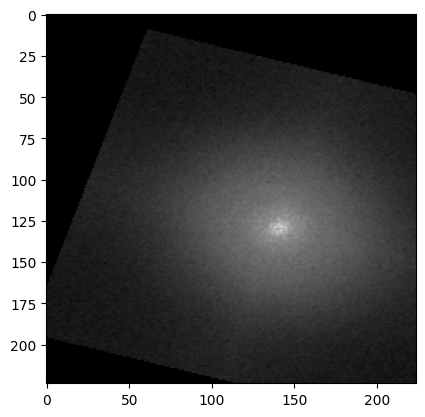

In [46]:
x = train_generator.next()
#for i in len(x):
image = x[0]
image = image[0]
plt.imshow(image)
plt.show()

In [49]:
DF_VAL

,Unnamed: 0.1,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset
0,348,348,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072723,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072723...,/media/SSD/rheology2023/Glycerol_FFT/GLY10/GLY...,794,28.39,valid
1,349,349,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072723,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072723...,/media/SSD/rheology2023/Glycerol_FFT/GLY10/GLY...,1000,35.39,valid
2,350,350,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072723,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072723...,/media/SSD/rheology2023/Glycerol_FFT/GLY10/GLY...,31,1.04,valid
3,351,351,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072723,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072723...,/media/SSD/rheology2023/Glycerol_FFT/GLY10/GLY...,630,22.67,valid
4,352,352,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072723,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072723...,/media/SSD/rheology2023/Glycerol_FFT/GLY10/GLY...,398,14.37,valid
...,...,...,...,...,...,...,...,...,...
3852,23601,23601,GLY80,GLY80P100_D0_30HZ_20XINF_UWELL_20221228_123520,GLY80P100_D0_30HZ_20XINF_UWELL_20221228_123520...,/media/SSD/rheology2023/Glycerol_FFT/GLY80/GLY...,125,0.11,valid
3853,23602,23602,GLY80,GLY80P100_D0_30HZ_20XINF_UWELL_20221228_123520,GLY80P100_D0_30HZ_20XINF_UWELL_20221228_123520...,/media/SSD/rheology2023/Glycerol_FFT/GLY80/GLY...,251,0.23,valid
3854,23603,23603,GLY80,GLY80P100_D0_30HZ_20XINF_UWELL_20221228_123520,GLY80P100_D0_30HZ_20XINF_UWELL_20221228_123520...,/media/SSD/rheology2023/Glycerol_FFT/GLY80/GLY...,1,0.00,valid
3855,23604,23604,GLY80,GLY80P100_D0_30HZ_20XINF_UWELL_20221228_123520,GLY80P100_D0_30HZ_20XINF_UWELL_20221228_123520...,/media/SSD/rheology2023/Glycerol_FFT/GLY80/GLY...,2,0.00,valid


In [51]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    return result[0]

#Predict
pred_list = list()
prob_list = list()
img_path=DF_VAL['pathimg'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    print(predict)
#     result = np.argmax(predict)
#     pred_list.append(labels[result])
#     prob_list.append(predict[result])

1/1 [==============================] - 4s 4s/step
[4.0334454]
1/1 [==============================] - 0s 64ms/step
[4.1604853]
1/1 [==============================] - 0s 68ms/step
[2.9156227]
1/1 [==============================] - 0s 70ms/step
[4.1473656]
1/1 [==============================] - 0s 66ms/step
[3.3285947]
1/1 [==============================] - 0s 64ms/step
[2.559225]
1/1 [==============================] - 0s 71ms/step
[2.9895754]
1/1 [==============================] - 0s 74ms/step
[2.287483]
1/1 [==============================] - 0s 67ms/step
[2.5032332]
1/1 [==============================] - 0s 68ms/step
[2.4888296]
1/1 [==============================] - 0s 70ms/step
[2.883403]
1/1 [==============================] - 0s 69ms/step
[2.97177]
1/1 [==============================] - 0s 64ms/step
[3.0036573]
1/1 [==============================] - 0s 65ms/step
[1.7693087]
1/1 [==============================] - 0s 69ms/step
[2.8893704]
1/1 [==============================] - 0s 74ms/

1/1 [==============================] - 0s 79ms/step
[2.5142345]
1/1 [==============================] - 0s 69ms/step
[3.64682]
1/1 [==============================] - 0s 74ms/step
[4.0209446]
1/1 [==============================] - 0s 71ms/step
[2.1026807]
1/1 [==============================] - 0s 74ms/step
[1.394379]
1/1 [==============================] - 0s 71ms/step
[2.2882934]
1/1 [==============================] - 0s 70ms/step
[3.1262095]
1/1 [==============================] - 0s 68ms/step
[2.8587232]
1/1 [==============================] - 0s 72ms/step
[3.8987725]
1/1 [==============================] - 0s 68ms/step
[2.9862213]
1/1 [==============================] - 0s 74ms/step
[3.586939]
1/1 [==============================] - 0s 69ms/step
[3.373689]
1/1 [==============================] - 0s 70ms/step
[2.9483936]
1/1 [==============================] - 0s 73ms/step
[1.8489857]
1/1 [==============================] - 0s 67ms/step
[2.5037282]
1/1 [==============================] - 0s 71m

1/1 [==============================] - 0s 72ms/step
[3.7355638]
1/1 [==============================] - 0s 67ms/step
[3.4852192]
1/1 [==============================] - 0s 66ms/step
[2.4951818]
1/1 [==============================] - 0s 72ms/step
[2.9747949]
1/1 [==============================] - 0s 74ms/step
[3.1058881]
1/1 [==============================] - 0s 71ms/step
[2.5549095]
1/1 [==============================] - 0s 65ms/step
[3.516634]
1/1 [==============================] - 0s 67ms/step
[3.1484704]
1/1 [==============================] - 0s 66ms/step
[2.1733499]
1/1 [==============================] - 0s 68ms/step
[2.964396]
1/1 [==============================] - 0s 65ms/step
[4.6196756]
1/1 [==============================] - 0s 70ms/step
[3.7768488]
1/1 [==============================] - 0s 67ms/step
[4.4293003]
1/1 [==============================] - 0s 68ms/step
[3.357027]
1/1 [==============================] - 0s 68ms/step
[5.2099376]
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 71ms/step
[2.0781057]
1/1 [==============================] - 0s 64ms/step
[3.4004567]
1/1 [==============================] - 0s 64ms/step
[2.5126803]
1/1 [==============================] - 0s 62ms/step
[3.754098]
1/1 [==============================] - 0s 66ms/step
[3.910792]
1/1 [==============================] - 0s 70ms/step
[2.8801167]
1/1 [==============================] - 0s 68ms/step
[1.9618614]
1/1 [==============================] - 0s 64ms/step
[3.1607223]
1/1 [==============================] - 0s 65ms/step
[3.5098403]
1/1 [==============================] - 0s 67ms/step
[2.4806898]
1/1 [==============================] - 0s 74ms/step
[2.2380266]
1/1 [==============================] - 0s 68ms/step
[2.6648545]
1/1 [==============================] - 0s 68ms/step
[3.3137193]
1/1 [==============================] - 0s 69ms/step
[2.2946105]
1/1 [==============================] - 0s 68ms/step
[1.9877802]
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 71ms/step
[1.7910099]
1/1 [==============================] - 0s 88ms/step
[2.6763856]
1/1 [==============================] - 0s 76ms/step
[2.7651186]
1/1 [==============================] - 0s 73ms/step
[3.3125575]
1/1 [==============================] - 0s 65ms/step
[5.0283184]
1/1 [==============================] - 0s 71ms/step
[4.1716094]
1/1 [==============================] - 0s 71ms/step
[3.6189594]
1/1 [==============================] - 0s 79ms/step
[3.1969957]
1/1 [==============================] - 0s 69ms/step
[4.603327]
1/1 [==============================] - 0s 70ms/step
[2.5964885]
1/1 [==============================] - 0s 68ms/step
[3.569892]
1/1 [==============================] - 0s 70ms/step
[3.5010526]
1/1 [==============================] - 0s 71ms/step
[2.272617]
1/1 [==============================] - 0s 72ms/step
[2.0779476]
1/1 [==============================] - 0s 72ms/step
[2.2230966]
1/1 [==============================] - 0s 7

1/1 [==============================] - 0s 71ms/step
[2.5088434]
1/1 [==============================] - 0s 70ms/step
[3.8572576]
1/1 [==============================] - 0s 69ms/step
[2.5467212]
1/1 [==============================] - 0s 74ms/step
[3.289846]
1/1 [==============================] - 0s 68ms/step
[2.8290231]
1/1 [==============================] - 0s 67ms/step
[4.3749504]
1/1 [==============================] - 0s 62ms/step
[3.351023]
1/1 [==============================] - 0s 66ms/step
[2.241734]
1/1 [==============================] - 0s 67ms/step
[2.8591073]
1/1 [==============================] - 0s 70ms/step
[3.035589]
1/1 [==============================] - 0s 70ms/step
[2.566613]
1/1 [==============================] - 0s 69ms/step
[3.710461]
1/1 [==============================] - 0s 63ms/step
[1.8509461]
1/1 [==============================] - 0s 64ms/step
[3.27943]
1/1 [==============================] - 0s 68ms/step
[3.3298476]
1/1 [==============================] - 0s 68ms/s

1/1 [==============================] - 0s 67ms/step
[3.6319287]
1/1 [==============================] - 0s 66ms/step
[2.6766577]
1/1 [==============================] - 0s 64ms/step
[4.9347916]
1/1 [==============================] - 0s 72ms/step
[2.812838]
1/1 [==============================] - 0s 68ms/step
[2.9594512]
1/1 [==============================] - 0s 67ms/step
[3.2382245]
1/1 [==============================] - 0s 66ms/step
[3.1308055]
1/1 [==============================] - 0s 68ms/step
[2.3094788]
1/1 [==============================] - 0s 70ms/step
[1.6332294]
1/1 [==============================] - 0s 81ms/step
[2.5734575]
1/1 [==============================] - 0s 66ms/step
[4.2889123]
1/1 [==============================] - 0s 66ms/step
[3.177352]
1/1 [==============================] - 0s 67ms/step
[2.7400157]
1/1 [==============================] - 0s 68ms/step
[2.7488341]
1/1 [==============================] - 0s 76ms/step
[3.8799598]
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 83ms/step
[2.8146505]
1/1 [==============================] - 0s 69ms/step
[2.9217572]
1/1 [==============================] - 0s 68ms/step
[2.6727118]
1/1 [==============================] - 0s 72ms/step
[3.7189884]
1/1 [==============================] - 0s 83ms/step
[1.9488606]
1/1 [==============================] - 0s 68ms/step
[2.2442136]
1/1 [==============================] - 0s 65ms/step
[2.7849925]
1/1 [==============================] - 0s 76ms/step
[2.5697932]
1/1 [==============================] - 0s 70ms/step
[2.8319497]
1/1 [==============================] - 0s 71ms/step
[4.320579]
1/1 [==============================] - 0s 67ms/step
[2.705591]
1/1 [==============================] - 0s 68ms/step
[2.452645]
1/1 [==============================] - 0s 73ms/step
[3.5493445]
1/1 [==============================] - 0s 69ms/step
[3.517972]
1/1 [==============================] - 0s 68ms/step
[2.182467]
1/1 [==============================] - 0s 67m

1/1 [==============================] - 0s 68ms/step
[5.1625314]
1/1 [==============================] - 0s 71ms/step
[2.7811356]
1/1 [==============================] - 0s 57ms/step
[1.731393]
1/1 [==============================] - 0s 70ms/step
[6.674307]
1/1 [==============================] - 0s 71ms/step
[2.0214872]
1/1 [==============================] - 0s 70ms/step
[2.0015807]
1/1 [==============================] - 0s 64ms/step
[1.8928187]
1/1 [==============================] - 0s 66ms/step
[1.4085258]
1/1 [==============================] - 0s 63ms/step
[1.9954159]
1/1 [==============================] - 0s 65ms/step
[3.574977]
1/1 [==============================] - 0s 69ms/step
[1.9989551]
1/1 [==============================] - 0s 71ms/step
[1.8950931]
1/1 [==============================] - 0s 70ms/step
[6.336706]
1/1 [==============================] - 0s 67ms/step
[1.5421399]
1/1 [==============================] - 0s 71ms/step
[2.511566]
1/1 [==============================] - 0s 70m

1/1 [==============================] - 0s 65ms/step
[1.6534271]
1/1 [==============================] - 0s 68ms/step
[1.5171905]
1/1 [==============================] - 0s 70ms/step
[2.111447]
1/1 [==============================] - 0s 71ms/step
[1.1374964]
1/1 [==============================] - 0s 74ms/step
[3.7940688]
1/1 [==============================] - 0s 73ms/step
[3.079696]
1/1 [==============================] - 0s 71ms/step
[2.007855]
1/1 [==============================] - 0s 72ms/step
[2.382221]
1/1 [==============================] - 0s 77ms/step
[3.0481856]
1/1 [==============================] - 0s 64ms/step
[0.7831032]
1/1 [==============================] - 0s 66ms/step
[1.8624216]
1/1 [==============================] - 0s 90ms/step
[2.3777041]
1/1 [==============================] - 0s 68ms/step
[3.5443752]
1/1 [==============================] - 0s 70ms/step
[2.7404685]
1/1 [==============================] - 0s 70ms/step
[3.591014]
1/1 [==============================] - 0s 67m

1/1 [==============================] - 0s 70ms/step
[1.7528155]
1/1 [==============================] - 0s 71ms/step
[1.8273011]
1/1 [==============================] - 0s 65ms/step
[1.731868]
1/1 [==============================] - 0s 69ms/step
[2.4241]
1/1 [==============================] - 0s 71ms/step
[2.4522355]
1/1 [==============================] - 0s 71ms/step
[3.091446]
1/1 [==============================] - 0s 65ms/step
[1.4460217]
1/1 [==============================] - 0s 68ms/step
[1.0813259]
1/1 [==============================] - 0s 70ms/step
[1.2445604]
1/1 [==============================] - 0s 66ms/step
[1.8513445]
1/1 [==============================] - 0s 71ms/step
[1.8726305]
1/1 [==============================] - 0s 62ms/step
[1.4590565]
1/1 [==============================] - 0s 68ms/step
[2.0159118]
1/1 [==============================] - 0s 65ms/step
[2.2950678]
1/1 [==============================] - 0s 63ms/step
[1.6961826]
1/1 [==============================] - 0s 68m

1/1 [==============================] - 0s 69ms/step
[1.4293617]
1/1 [==============================] - 0s 66ms/step
[3.840785]
1/1 [==============================] - 0s 71ms/step
[3.066187]
1/1 [==============================] - 0s 68ms/step
[1.1825098]
1/1 [==============================] - 0s 70ms/step
[1.4683143]
1/1 [==============================] - 0s 71ms/step
[2.9526367]
1/1 [==============================] - 0s 73ms/step
[2.4779136]
1/1 [==============================] - 0s 72ms/step
[2.436406]
1/1 [==============================] - 0s 70ms/step
[1.5677711]
1/1 [==============================] - 0s 66ms/step
[3.848256]
1/1 [==============================] - 0s 70ms/step
[1.8035423]
1/1 [==============================] - 0s 68ms/step
[1.4886645]
1/1 [==============================] - 0s 67ms/step
[1.3969748]
1/1 [==============================] - 0s 87ms/step
[2.8993304]
1/1 [==============================] - 0s 66ms/step
[1.0021734]
1/1 [==============================] - 0s 66

1/1 [==============================] - 0s 74ms/step
[3.6584184]
1/1 [==============================] - 0s 99ms/step
[2.0865595]
1/1 [==============================] - 0s 77ms/step
[3.5845866]
1/1 [==============================] - 0s 74ms/step
[1.7122785]
1/1 [==============================] - 0s 73ms/step
[3.5286386]
1/1 [==============================] - 0s 68ms/step
[2.7641704]
1/1 [==============================] - 0s 71ms/step
[1.5416697]
1/1 [==============================] - 0s 67ms/step
[2.765901]
1/1 [==============================] - 0s 83ms/step
[3.3634844]
1/1 [==============================] - 0s 73ms/step
[2.6601784]
1/1 [==============================] - 0s 76ms/step
[3.1879537]
1/1 [==============================] - 0s 74ms/step
[3.4798114]
1/1 [==============================] - 0s 73ms/step
[1.3151815]
1/1 [==============================] - 0s 70ms/step
[2.4770718]
1/1 [==============================] - 0s 71ms/step
[3.8518114]
1/1 [==============================] - 0s

1/1 [==============================] - 0s 68ms/step
[1.8515652]
1/1 [==============================] - 0s 69ms/step
[4.3553834]
1/1 [==============================] - 0s 67ms/step
[3.987866]
1/1 [==============================] - 0s 63ms/step
[3.1184263]
1/1 [==============================] - 0s 66ms/step
[3.382319]
1/1 [==============================] - 0s 67ms/step
[2.104226]
1/1 [==============================] - 0s 68ms/step
[2.3668578]
1/1 [==============================] - 0s 66ms/step
[3.32547]
1/1 [==============================] - 0s 69ms/step
[1.8362002]
1/1 [==============================] - 0s 64ms/step
[2.1974888]
1/1 [==============================] - 0s 72ms/step
[2.8314698]
1/1 [==============================] - 0s 69ms/step
[2.4595969]
1/1 [==============================] - 0s 72ms/step
[2.615981]
1/1 [==============================] - 0s 70ms/step
[3.1437008]
1/1 [==============================] - 0s 69ms/step
[3.635942]
1/1 [==============================] - 0s 63ms/

1/1 [==============================] - 0s 66ms/step
[2.0077612]
1/1 [==============================] - 0s 68ms/step
[1.9607552]
1/1 [==============================] - 0s 66ms/step
[2.8190708]
1/1 [==============================] - 0s 65ms/step
[2.7852507]
1/1 [==============================] - 0s 70ms/step
[1.9795399]
1/1 [==============================] - 0s 75ms/step
[3.5893385]
1/1 [==============================] - 0s 68ms/step
[1.4940479]
1/1 [==============================] - 0s 67ms/step
[1.504376]
1/1 [==============================] - 0s 67ms/step
[2.47722]
1/1 [==============================] - 0s 72ms/step
[3.0261326]
1/1 [==============================] - 0s 74ms/step
[2.254639]
1/1 [==============================] - 0s 68ms/step
[1.6475943]
1/1 [==============================] - 0s 68ms/step
[1.8706695]
1/1 [==============================] - 0s 68ms/step
[1.4250087]
1/1 [==============================] - 0s 68ms/step
[2.0039806]
1/1 [==============================] - 0s 69

1/1 [==============================] - 0s 68ms/step
[2.7366893]
1/1 [==============================] - 0s 70ms/step
[3.7434518]
1/1 [==============================] - 0s 66ms/step
[2.3189054]
1/1 [==============================] - 0s 74ms/step
[2.864827]
1/1 [==============================] - 0s 71ms/step
[1.3657175]
1/1 [==============================] - 0s 61ms/step
[2.6026134]
1/1 [==============================] - 0s 73ms/step
[1.0562781]
1/1 [==============================] - 0s 68ms/step
[2.6670773]
1/1 [==============================] - 0s 68ms/step
[3.3687384]
1/1 [==============================] - 0s 66ms/step
[5.7983236]
1/1 [==============================] - 0s 73ms/step
[1.5230279]
1/1 [==============================] - 0s 67ms/step
[1.3092092]
1/1 [==============================] - 0s 62ms/step
[2.417996]
1/1 [==============================] - 0s 68ms/step
[2.9608235]
1/1 [==============================] - 0s 65ms/step
[3.9194028]
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 71ms/step
[2.243403]
1/1 [==============================] - 0s 71ms/step
[4.249554]
1/1 [==============================] - 0s 69ms/step
[2.9707444]
1/1 [==============================] - 0s 71ms/step
[1.8516817]
1/1 [==============================] - 0s 71ms/step
[3.8036027]
1/1 [==============================] - 0s 60ms/step
[3.678753]
1/1 [==============================] - 0s 61ms/step
[1.5096623]
1/1 [==============================] - 0s 69ms/step
[2.1852772]
1/1 [==============================] - 0s 72ms/step
[2.7411056]
1/1 [==============================] - 0s 70ms/step
[2.6410317]
1/1 [==============================] - 0s 70ms/step
[3.9681714]
1/1 [==============================] - 0s 70ms/step
[3.3050091]
1/1 [==============================] - 0s 78ms/step
[3.648477]
1/1 [==============================] - 0s 68ms/step
[2.1452906]
1/1 [==============================] - 0s 62ms/step
[3.462511]
1/1 [==============================] - 0s 62m

1/1 [==============================] - 0s 67ms/step
[4.5027013]
1/1 [==============================] - 0s 65ms/step
[1.5621334]
1/1 [==============================] - 0s 72ms/step
[0.5895495]
1/1 [==============================] - 0s 70ms/step
[1.9677454]
1/1 [==============================] - 0s 69ms/step
[3.2992823]
1/1 [==============================] - 0s 73ms/step
[1.4841274]
1/1 [==============================] - 0s 71ms/step
[2.6046798]
1/1 [==============================] - 0s 63ms/step
[2.3939743]
1/1 [==============================] - 0s 69ms/step
[1.6139883]
1/1 [==============================] - 0s 68ms/step
[1.1462363]
1/1 [==============================] - 0s 70ms/step
[2.5241394]
1/1 [==============================] - 0s 68ms/step
[5.140048]
1/1 [==============================] - 0s 67ms/step
[1.442091]
1/1 [==============================] - 0s 63ms/step
[1.5856869]
1/1 [==============================] - 0s 92ms/step
[1.0249989]
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 65ms/step
[2.1379118]
1/1 [==============================] - 0s 67ms/step
[3.2288647]
1/1 [==============================] - 0s 66ms/step
[1.7701244]
1/1 [==============================] - 0s 72ms/step
[2.2014892]
1/1 [==============================] - 0s 74ms/step
[1.1936868]
1/1 [==============================] - 0s 76ms/step
[3.5806386]
1/1 [==============================] - 0s 69ms/step
[2.4778266]
1/1 [==============================] - 0s 76ms/step
[2.2787898]
1/1 [==============================] - 0s 70ms/step
[1.5665488]
1/1 [==============================] - 0s 72ms/step
[1.3742079]
1/1 [==============================] - 0s 72ms/step
[4.067582]
1/1 [==============================] - 0s 68ms/step
[3.40856]
1/1 [==============================] - 0s 74ms/step
[4.1871233]
1/1 [==============================] - 0s 70ms/step
[3.686773]
1/1 [==============================] - 0s 70ms/step
[2.5068426]
1/1 [==============================] - 0s 68

1/1 [==============================] - 0s 70ms/step
[5.580567]
1/1 [==============================] - 0s 65ms/step
[6.0931263]
1/1 [==============================] - 0s 66ms/step
[4.119518]
1/1 [==============================] - 0s 66ms/step
[2.2669706]
1/1 [==============================] - 0s 70ms/step
[2.4564462]
1/1 [==============================] - 0s 72ms/step
[2.4966447]
1/1 [==============================] - 0s 64ms/step
[2.9376884]
1/1 [==============================] - 0s 115ms/step
[2.8140655]
1/1 [==============================] - 0s 61ms/step
[2.099804]
1/1 [==============================] - 0s 62ms/step
[1.5961154]
1/1 [==============================] - 0s 68ms/step
[1.9194766]
1/1 [==============================] - 0s 70ms/step
[3.085957]
1/1 [==============================] - 0s 71ms/step
[2.8007114]
1/1 [==============================] - 0s 68ms/step
[2.1922164]
1/1 [==============================] - 0s 73ms/step
[0.9086174]
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 68ms/step
[2.1165311]
1/1 [==============================] - 0s 64ms/step
[2.8691812]
1/1 [==============================] - 0s 65ms/step
[3.318616]
1/1 [==============================] - 0s 69ms/step
[1.946824]
1/1 [==============================] - 0s 69ms/step
[3.0591574]
1/1 [==============================] - 0s 70ms/step
[2.4742281]
1/1 [==============================] - 0s 66ms/step
[0.7430429]
1/1 [==============================] - 0s 69ms/step
[2.6087182]
1/1 [==============================] - 0s 68ms/step
[3.7894742]
1/1 [==============================] - 0s 64ms/step
[2.4187627]
1/1 [==============================] - 0s 71ms/step
[2.4498332]
1/1 [==============================] - 0s 69ms/step
[4.6787286]
1/1 [==============================] - 0s 72ms/step
[2.385697]
1/1 [==============================] - 0s 76ms/step
[2.443185]
1/1 [==============================] - 0s 73ms/step
[2.7572956]
1/1 [==============================] - 0s 66

1/1 [==============================] - 0s 68ms/step
[2.598725]
1/1 [==============================] - 0s 68ms/step
[1.6348819]
1/1 [==============================] - 0s 67ms/step
[1.9333435]
1/1 [==============================] - 0s 65ms/step
[4.623046]
1/1 [==============================] - 0s 76ms/step
[1.737399]
1/1 [==============================] - 0s 89ms/step
[3.6929693]
1/1 [==============================] - 0s 73ms/step
[2.7903554]
1/1 [==============================] - 0s 68ms/step
[2.3599825]
1/1 [==============================] - 0s 68ms/step
[1.2319705]
1/1 [==============================] - 0s 71ms/step
[1.977426]
1/1 [==============================] - 0s 68ms/step
[3.0120883]
1/1 [==============================] - 0s 68ms/step
[3.2855856]
1/1 [==============================] - 0s 71ms/step
[3.2639592]
1/1 [==============================] - 0s 66ms/step
[4.4639115]
1/1 [==============================] - 0s 66ms/step
[2.6387258]
1/1 [==============================] - 0s 63

1/1 [==============================] - 0s 71ms/step
[3.3126724]
1/1 [==============================] - 0s 71ms/step
[2.1027536]
1/1 [==============================] - 0s 68ms/step
[3.0918627]
1/1 [==============================] - 0s 67ms/step
[1.9229878]
1/1 [==============================] - 0s 73ms/step
[2.0786471]
1/1 [==============================] - 0s 72ms/step
[1.3478063]
1/1 [==============================] - 0s 68ms/step
[3.0808842]
1/1 [==============================] - 0s 68ms/step
[3.4587169]
1/1 [==============================] - 0s 70ms/step
[0.44013909]
1/1 [==============================] - 0s 72ms/step
[2.287823]
1/1 [==============================] - 0s 73ms/step
[2.13114]
1/1 [==============================] - 0s 66ms/step
[1.4143335]
1/1 [==============================] - 0s 71ms/step
[0.677991]
1/1 [==============================] - 0s 71ms/step
[1.6084646]
1/1 [==============================] - 0s 69ms/step
[2.8819714]
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 71ms/step
[3.0995636]
1/1 [==============================] - 0s 70ms/step
[3.1854174]
1/1 [==============================] - 0s 68ms/step
[2.1581588]
1/1 [==============================] - 0s 68ms/step
[1.9145962]
1/1 [==============================] - 0s 67ms/step
[1.385456]
1/1 [==============================] - 0s 63ms/step
[2.1981778]
1/1 [==============================] - 0s 64ms/step
[0.79641557]
1/1 [==============================] - 0s 66ms/step
[1.034593]
1/1 [==============================] - 0s 64ms/step
[1.3100511]
1/1 [==============================] - 0s 69ms/step
[1.393643]
1/1 [==============================] - 0s 66ms/step
[2.2363796]
1/1 [==============================] - 0s 75ms/step
[2.2019806]
1/1 [==============================] - 0s 74ms/step
[2.0041277]
1/1 [==============================] - 0s 70ms/step
[1.4186078]
1/1 [==============================] - 0s 73ms/step
[1.0912036]
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 74ms/step
[3.799286]
1/1 [==============================] - 0s 75ms/step
[1.186271]
1/1 [==============================] - 0s 71ms/step
[2.9063005]
1/1 [==============================] - 0s 69ms/step
[2.128616]
1/1 [==============================] - 0s 69ms/step
[2.204199]
1/1 [==============================] - 0s 74ms/step
[1.2379321]
1/1 [==============================] - 0s 70ms/step
[2.3373406]
1/1 [==============================] - 0s 72ms/step
[2.170675]
1/1 [==============================] - 0s 73ms/step
[3.409442]
1/1 [==============================] - 0s 64ms/step
[0.85269755]
1/1 [==============================] - 0s 70ms/step
[2.3599524]
1/1 [==============================] - 0s 89ms/step
[2.449413]
1/1 [==============================] - 0s 69ms/step
[1.8766834]
1/1 [==============================] - 0s 69ms/step
[1.6038791]
1/1 [==============================] - 0s 69ms/step
[1.9911062]
1/1 [==============================] - 0s 72ms

KeyboardInterrupt: 

1/1 [==============================] - 3s 3s/step


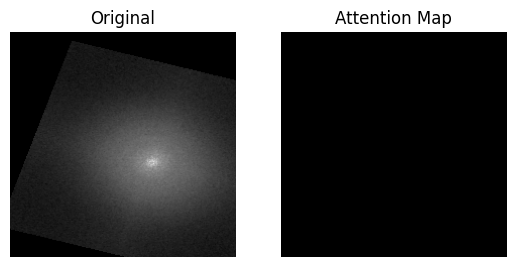

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from vit_keras import vit, utils, visualize

# Load a model
image_size = 224
# classes = utils.get_imagenet_classes()
# model = vit.vit_b16(
#     image_size=image_size,
#     activation='sigmoid',
#     pretrained=True,
#     include_top=True,
#     pretrained_top=True
# )
# classes = utils.get_imagenet_classes()

# # Get an image and compute the attention map
# url = 'https://upload.wikimedia.org/wikipedia/commons/b/bc/Free%21_%283987584939%29.jpg'
# image = utils.read(url, image_size)

attention_map = visualize.attention_map(model=model, image=image)
# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [13]:
### ViT model with the functional ###
from vit_keras import vit, utils

vit_model = vit.vit_l32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 14)
vit_model.summary()

Model: "vit-l32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 1024)        3146752   
                                                                 
 reshape_1 (Reshape)         (None, 49, 1024)          0         
                                                                 
 class_token (ClassToken)    (None, 50, 1024)          1024      
                                                                 
 Transformer/posembed_input   (None, 50, 1024)         51200     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 1024),       12596224  
 (TransformerBlock)           (None, 16, None, None))      

In [53]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(1, 'linear')
    ],
    name = 'visionregress_transformer')

model.summary()

Model: "visionregress_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-l32 (Functional)        (None, 1024)              305510400 
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 64)  

In [55]:
cls_token_layer = model.get_layer("class_token")
cls_token_var = model.cls.value()

model.shape

ValueError: No such layer: class_token. Existing layers are: ['vit-l32', 'flatten_2', 'batch_normalization_2', 'dense_4', 'batch_normalization_3', 'dense_5', 'dense_6', 'dense_7'].